# ЛР1 ­- Задача предсказания оттока клиентов банка

Построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.
Значения столбцов таблицы:

• RowNumber — номер строки таблицы;

• CustomerId — идентификатор клиента;

• Surname — фамилия клиента;

• CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и
возвращал их);

• Geography — страна проживания клиента (банк межнациональный);

• Gender — пол клиента;

• Age — возраст клиента;

• Tenure — сколько лет клиент пользуется банком;

• Balance — сколько у клиента денег на счетах в банке;

• NumOfProduct — число услуг банка, которыми воспользовался клиент;

• HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);

• IsActiveMember — есть ли у клиента статус «активный клиент» (1 — да, 0 — нет);

• EstimatedSalary — предполагаемая заработная плата клиента;

• Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).


# Устаовка библиотек

In [1]:
%pip install pandas matplotlib seaborn numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


# Импортируем и убираем предупреждения

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn import linear_model, metrics, preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns

warnings.filterwarnings('ignore')

# Загрузка данных

In [3]:
data = pd.read_csv('../data/churn.csv')

# Проверка наличия пропущенных значений

In [4]:
print(data.isnull().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


# Визуализация сбалансированности классов

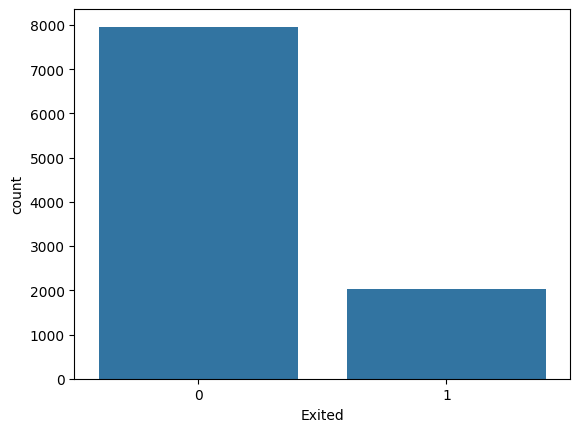

In [5]:
sns.countplot(x='Exited', data=data)
plt.show()

# Выделение категориальных признаков

In [6]:
cat_features = data.select_dtypes(include=['object']).columns.tolist()
print("Категориальные признаки:", cat_features)

Категориальные признаки: ['Surname', 'Geography', 'Gender']


# Копирование данных для дальнейшей работы

In [7]:
churn_data = data.copy()

# Удаление неинформативных признаков

In [8]:
churn_data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1, inplace=True)

# Проверка уникальных значений категориальных признаков

In [9]:
print("Уникальные значения Geography:", churn_data['Geography'].unique())
print("Уникальные значения Gender:", churn_data['Gender'].unique())

Уникальные значения Geography: ['France' 'Spain' 'Germany']
Уникальные значения Gender: ['Female' 'Male']


# Преобразование категориальных признаков в dummy-переменные

In [10]:
churn_data = pd.get_dummies(churn_data, drop_first=True)

# Формирование матрицы признаков и целевой переменной

In [11]:
X = churn_data.drop(['Exited'], axis=1)
y = churn_data['Exited']

# Разделение данных на обучающую и тестовую выборки

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)

# Масштабирование данных с помощью Min-Max нормализации

In [13]:
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание и обучение модели логистической регрессии

In [14]:
log_reg = linear_model.LogisticRegression(solver='sag', random_state=1, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='sag')

# Прогнозирование на обучающей и тестовой выборках

In [15]:
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Отчёт о метриках классификации

In [16]:
print("Отчёт о метриках классификации на обучающей выборке:")
print(classification_report(y_train, y_train_pred))
print("Отчёт о метриках классификации на тестовой выборке:")
print(classification_report(y_test, y_test_pred))

Отчёт о метриках классификации на обучающей выборке:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      6370
           1       0.62      0.20      0.31      1630

    accuracy                           0.81      8000
   macro avg       0.72      0.59      0.60      8000
weighted avg       0.78      0.81      0.77      8000

Отчёт о метриках классификации на тестовой выборке:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.61      0.19      0.29       407

    accuracy                           0.81      2000
   macro avg       0.72      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



# Определение оптимального порога вероятности

In [17]:
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
recall_scores, precision_scores, f1_scores = [], [], []
thresholds = np.arange(0.1, 1, 0.05)
for threshold in thresholds:
    y_test_pred_threshold = (y_test_proba > threshold).astype(int)
    recall_scores.append(metrics.recall_score(y_test, y_test_pred_threshold))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred_threshold))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred_threshold))


# Визуализация метрик при различных порогах

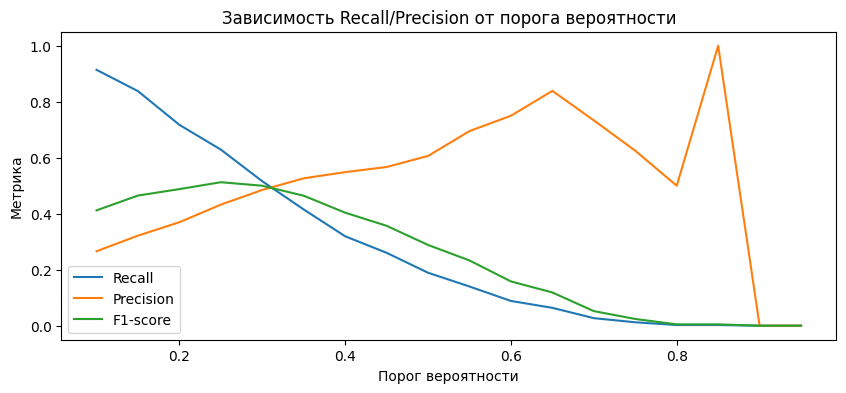

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, f1_scores, label='F1-score')
plt.title('Зависимость Recall/Precision от порога вероятности')
plt.xlabel('Порог вероятности')
plt.ylabel('Метрика')
plt.legend()
plt.show()

# Установка оптимального порога вероятности

In [19]:
optimal_threshold = 0.3
y_test_pred_opt = (y_test_proba > optimal_threshold).astype(int)

# Итоговый отчёт о метриках классификации

In [20]:
print("Итоговый отчёт о метриках классификации с оптимальным порогом:")
print(metrics.classification_report(y_test, y_test_pred_opt))


Итоговый отчёт о метриках классификации с оптимальным порогом:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1593
           1       0.48      0.52      0.50       407

    accuracy                           0.79      2000
   macro avg       0.68      0.69      0.68      2000
weighted avg       0.80      0.79      0.79      2000

